# Incoherent Summing for patchy surfaces

If you have patchy areas on a surface (> coherence length of neutron) you may want to average the reflectivity signals from those different areas, a process called incoherent summing. In contrast if the lateral inhomogeneity lengthscale is less than the coherence length you want to be laterally averaging the scattering length density profile.

This example demonstrates the incoherent summing using `MixedReflectModel`. The steps are to first set up `Structure` for each of the patchy areas. Don't forget that you can re-use objects across different structures to enforce constraints/reduce parameterisation.

The example I'll create is a simple polymer layer on top of a silicon wafer, but it's the same process different systems. Incoherent averaging is used for: patchy lipid bilayers, thickness gradients of films across a surface, etc. I sometimes use ellipsometric thickness mapping to guide the incoherent summing in an NR analysis. 

This is a good paper that demonstrates incoherent averaging:

> [Gresham, Isaac J., et al. "Geometrical confinement modulates the thermoresponse of a poly (N-isopropylacrylamide) brush." Macromolecules 54.5 (2021): 2541-2550.](https://pubs.acs.org/doi/epdf/10.1021/acs.macromol.0c02775)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from refnx.analysis import Parameter
from refnx.reflect import (
    ReflectModel,
    SLD,
    Slab,
    Structure,
    MixedReflectModel,
    LipidLeaflet,
)

In [2]:
# SLDs
air = SLD(0.0)
sio2 = SLD(3.47)
polymer = SLD(1.0)
si = SLD(2.07)

In [3]:
# sio2 slab is common over all areas
sio2_layer = Slab(25, sio2, 3)

# the si/sio2 roughness is common across all areas
si_roughness = Parameter(3.0)

We're going to assume that the polymer coated area has two different thicknesses, one of which is 50% of the other. This kind of information can often be determined by ellipsometry. More complex thickness variations can be modelled with analytical thickness distributions, e.g. convex or concave domes. Note that the constraint is automatically propagated, i.e. if you change `polymer_thickness_0.value`, then this will be propagated to `polymer_thickness_1`.

In [4]:
polymer_thickness_0 = Parameter(200.0)
# the thickness constraint is applied automatically
polymer_thickness_1 = polymer_thickness_0 * 0.5

# polymer_thickness_1 = Parameter(constraint=polymer_thickness_0 * 0.5) # an alternate way of enforcing the constraint

polymer_l_0 = Slab(polymer_thickness_0, polymer, 4)
polymer_l_1 = Slab(polymer_thickness_1, polymer, 4)

In [5]:
structure_bare = air | sio2 | si(np.inf, si_roughness)
structure0 = air | polymer_l_0 | sio2 | si(np.inf, si_roughness)
structure1 = air | polymer_l_1 | sio2 | si(np.inf, si_roughness)

Once we have the structures that we wish to model we can set up the `MixedReflectModel` to incoherently sum the areas. `MixedReflectModel` is very similar to `ReflectModel` in the way it adds background, performs resolution smearing, etc.

In [6]:
model = MixedReflectModel(
    [structure_bare, structure0, structure1], scales=(0.2, 0.5, 1.3), bkg=1e-8
)

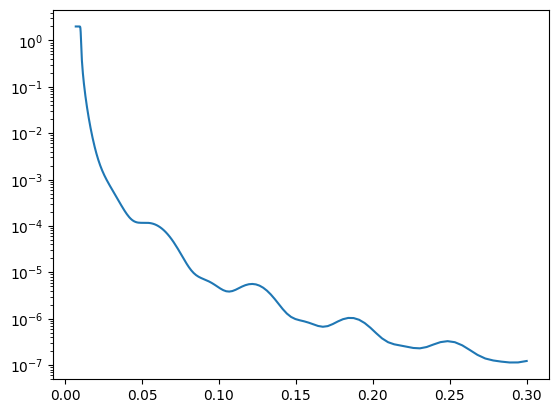

In [7]:
q = np.geomspace(0.007, 0.3, 201)
plt.plot(q, model(q))
plt.yscale("log");

If you were paying attention you'll see that the reflectivity below the critical edge is greater than 1. This is a consequence of 
`MixedReflectModel.scales` adding up to more than 1. Let's adjust the scales and replot, with the reflectivities from the different areas also displayed.
Note that the scales are applied in the same order that the individual structures were supplied to `MixedReflectModel`.

In [8]:
# Each of the scales is a Parameter, and are collectively held in a `Parameters` object that can be indexed.
model.scales[0].value = 0.2  # structure_bare
model.scales[1].value = 0.5  # structure0
model.scales[2].value = 0.3  # structure1

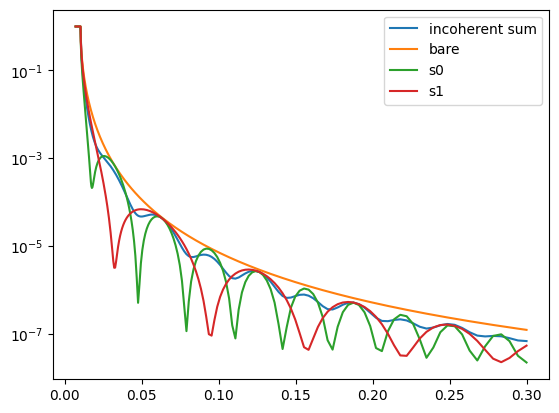

In [9]:
plt.plot(q, model(q), label="incoherent sum")
plt.plot(q, structure_bare.reflectivity(q), label="bare")
plt.plot(q, structure0.reflectivity(q), label="s0")
plt.plot(q, structure1.reflectivity(q), label="s1")
plt.yscale("log")
plt.legend();